In [0]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

#from jqmcvi import base    # For Dunn's index (refer: https://github.com/jqmviegas/jqm_cvi/blob/master/jqmcvi/base.py) for its python implementation.

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import silhouette_score   #To calculate the best n_clusters for KMeans Clustering (Refer: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [3]:
#--------------------Run this cell to mount your Google Drive-------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#--------------------Reading Data from Google Drive------------------------

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Reading the file from Googlr Drive

data = pd.read_excel("/content/drive/My Drive/ER/Clustering/EastWestAirlines.xlsx", sheet_name = "data")
#data_x = data.drop(labels = ["y"], axis = 1)
#data_y = data["y"]

In [6]:
data.head(20)

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1
5,6,16420,0,1,1,1,0,0,0,0,6942,0
6,7,84914,0,3,1,1,27482,25,0,0,6994,0
7,8,20856,0,1,1,1,5250,4,250,1,6938,1
8,9,443003,0,3,2,1,1753,43,3850,12,6948,1
9,10,104860,0,3,1,1,28426,28,1150,3,6931,1


In [0]:
sns.set_style("whitegrid")

In [8]:
data.describe()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000




*   Looking at the variables, it can be seen that "cc1_miles","cc2_miles","cc3_miles" and "Award?" is categorical in nature.



In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
ID#                  3999 non-null int64
Balance              3999 non-null int64
Qual_miles           3999 non-null int64
cc1_miles            3999 non-null int64
cc2_miles            3999 non-null int64
cc3_miles            3999 non-null int64
Bonus_miles          3999 non-null int64
Bonus_trans          3999 non-null int64
Flight_miles_12mo    3999 non-null int64
Flight_trans_12      3999 non-null int64
Days_since_enroll    3999 non-null int64
Award?               3999 non-null int64
dtypes: int64(12)
memory usage: 375.0 KB


In [0]:
#Converting categorical data so that it can used for further analysis.

dummy_cc1_miles = pd.get_dummies(data["cc1_miles"], prefix = "cc1_miles")
dummy_cc2_miles = pd.get_dummies(data["cc2_miles"], prefix = "cc2_miles")
dummy_cc3_miles = pd.get_dummies(data["cc3_miles"], prefix = "cc3_miles")
dummy_Award = pd.get_dummies(data["Award?"], prefix = "Award")

dummy = pd.concat([dummy_cc1_miles,dummy_cc2_miles,dummy_cc3_miles,dummy_Award], axis = 1 )

In [0]:
#Dropping the categorical variables from dataset.

data.drop(["cc1_miles", "cc2_miles", "cc3_miles", "Award?", "ID#"], inplace = True, axis = 1)

In [0]:
data = pd.concat([data, dummy], axis = 1)

In [13]:
data.head()

,Balance,Qual_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,cc1_miles_1,cc1_miles_2,cc1_miles_3,cc1_miles_4,cc1_miles_5,cc2_miles_1,cc2_miles_2,cc2_miles_3,cc3_miles_1,cc3_miles_2,cc3_miles_3,cc3_miles_4,cc3_miles_5,Award_0,Award_1
0,28143,0,174,1,0,0,7000,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,19244,0,215,2,0,0,6968,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,41354,0,4123,4,0,0,7034,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,14776,0,500,1,0,0,6952,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
4,97752,0,43300,26,2077,4,6935,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1


In [14]:
data.columns

Index(['Balance', 'Qual_miles', 'Bonus_miles', 'Bonus_trans',
       'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll',
       'cc1_miles_1', 'cc1_miles_2', 'cc1_miles_3', 'cc1_miles_4',
       'cc1_miles_5', 'cc2_miles_1', 'cc2_miles_2', 'cc2_miles_3',
       'cc3_miles_1', 'cc3_miles_2', 'cc3_miles_3', 'cc3_miles_4',
       'cc3_miles_5', 'Award_0', 'Award_1'],
      dtype='object')

In [0]:
#Normalizing dataset.

SS = StandardScaler()
data_scaled = pd.DataFrame(SS.fit_transform(data), columns = ['Balance', 'Qual_miles', 'Bonus_miles', 'Bonus_trans',
       'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll',
       'cc1_miles_1', 'cc1_miles_2', 'cc1_miles_3', 'cc1_miles_4',
       'cc1_miles_5', 'cc2_miles_1', 'cc2_miles_2', 'cc2_miles_3',
       'cc3_miles_1', 'cc3_miles_2', 'cc3_miles_3', 'cc3_miles_4',
       'cc3_miles_5', 'Award_0', 'Award_1'])

In [16]:
data_scaled.head()

,Balance,Qual_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,cc1_miles_1,cc1_miles_2,cc1_miles_3,cc1_miles_4,cc1_miles_5,cc2_miles_1,cc2_miles_2,cc2_miles_3,cc3_miles_1,cc3_miles_2,cc3_miles_3,cc3_miles_4,cc3_miles_5,Award_0,Award_1
0,-0.451141,-0.186299,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,0.864321,-0.27649,-0.425487,-0.388745,-0.278581,0.104257,-0.083971,-0.06136,0.067242,-0.0274,-0.031643,-0.038764,-0.035382,0.766919,-0.766919
1,-0.539457,-0.186299,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,0.864321,-0.27649,-0.425487,-0.388745,-0.278581,0.104257,-0.083971,-0.06136,0.067242,-0.0274,-0.031643,-0.038764,-0.035382,0.766919,-0.766919
2,-0.320031,-0.186299,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,0.864321,-0.27649,-0.425487,-0.388745,-0.278581,0.104257,-0.083971,-0.06136,0.067242,-0.0274,-0.031643,-0.038764,-0.035382,0.766919,-0.766919
3,-0.583799,-0.186299,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,0.864321,-0.27649,-0.425487,-0.388745,-0.278581,0.104257,-0.083971,-0.06136,0.067242,-0.0274,-0.031643,-0.038764,-0.035382,0.766919,-0.766919
4,0.239678,-0.186299,1.083121,1.499394,1.154932,0.692490,1.363975,-1.156977,-0.27649,-0.425487,2.572381,-0.278581,0.104257,-0.083971,-0.06136,0.067242,-0.0274,-0.031643,-0.038764,-0.035382,-1.303918,1.303918


##Performing PCA over the dataset.

In [0]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns = ["PC1","PC2"])

In [18]:
data_pca.head()

,PC1,PC2
0,-1.781111,0.147522
1,-1.765569,0.146013
2,-1.556105,0.154813
3,-1.813937,0.152330
4,3.384375,-0.343981


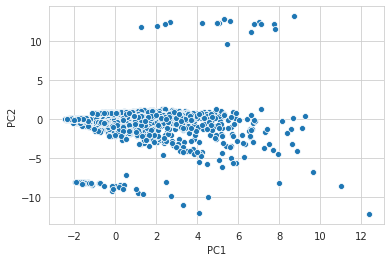

In [19]:
sns.scatterplot("PC1","PC2", data = data_pca)

##Performing KMeans Clustering

In [0]:
inertia = []
pred = {}
for k in list(range(1,10)):
  km = KMeans(n_clusters = k, max_iter = 500, precompute_distances = True,  random_state = 42)
  km.fit(data_pca)
  pred.update({k : list(km.fit_predict(data_pca))})
  #y_labels = set(km.labels_)
  inertia.append(km.inertia_)

Text(0, 0.5, 'Sum of Squared Distances(SSD)')

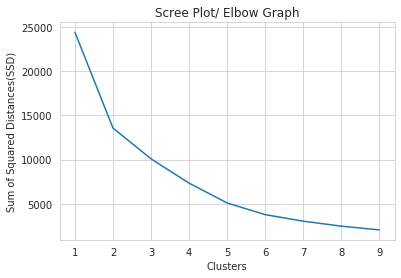

In [21]:
#Plotting the Scree plot for 1 to 9 clusters
plt.title("Scree Plot/ Elbow Graph")
sns.lineplot(x = list(range(1,10)), y = inertia, markers = True)
plt.xlabel("Clusters")
plt.ylabel("Sum of Squared Distances(SSD)")   #Looking at the graph, we can see that SSD is sufficiently low for clusters for [2,3,4]. 

In [22]:
#Calculating Silhouette Score to find out an optimal n_cluster value
for k in list(range(2,10)):
  ss = silhouette_score(data_pca, pred[k], random_state = 42)
  print("Silhouette score for: ", k, "Clusters: ", ss)

Silhouette score for:  2 Clusters:  0.5355393107818012
Silhouette score for:  3 Clusters:  0.5536995657928564
Silhouette score for:  4 Clusters:  0.5618055498204189
Silhouette score for:  5 Clusters:  0.5098353229550299
Silhouette score for:  6 Clusters:  0.5171830022757641
Silhouette score for:  7 Clusters:  0.5499114057068951
Silhouette score for:  8 Clusters:  0.5547797798692152
Silhouette score for:  9 Clusters:  0.5673100853458074




*   Looking at the Silhouette score, we can say that 4 clusters seems to be a good choice for clustering.



In [0]:
#Creating a scatter plot for each value of K
def scatter_plot(k, km, i, j) :
  sns.scatterplot("PC1", "PC2", data = data_pca, hue = km.labels_ , ax = ax[i][j] )
  plt.xlabel("Principal Component 1")
  plt.ylabel("Principal Component 2")
  plt.title("Scatter plot for N dimensions")

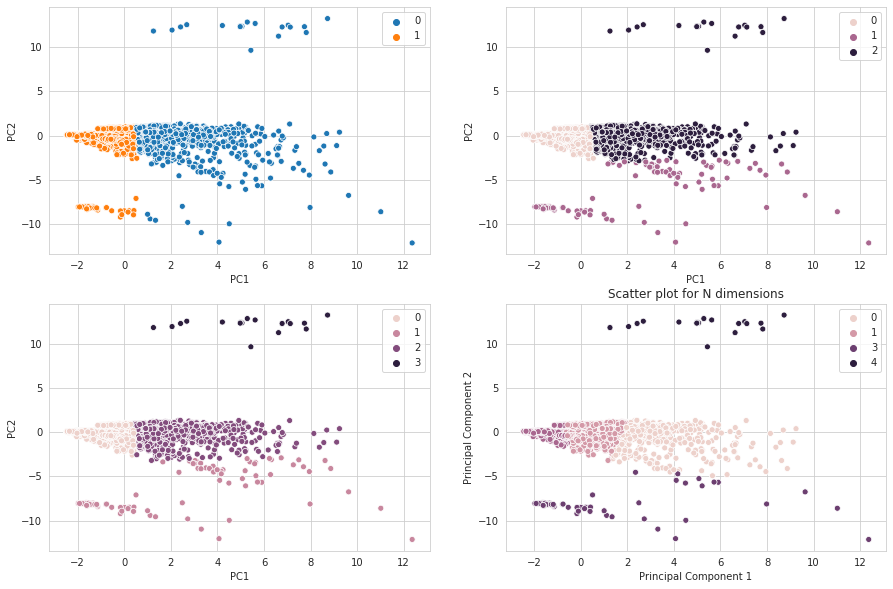

In [24]:
#Function to plot a scatter plot

fig, ax = plt.subplots(2,2,figsize = (15,10))
k = 2
inertia_selected = {}
for i in [0,1]:
  for j in [0,1]:
    if (k<=5):
      km = KMeans(n_clusters = k, max_iter = 500, random_state = 42, precompute_distances = True)
      km.fit(data_pca)
      inertia_selected[k] = round(km.inertia_, 3)
      #inertia_selected.append(km.inertia_)
      scatter_plot(k, km, i, j)
      k+=1

##Performing Agglomerative Clustering

Text(0.5, 1.0, 'Dendrogram')

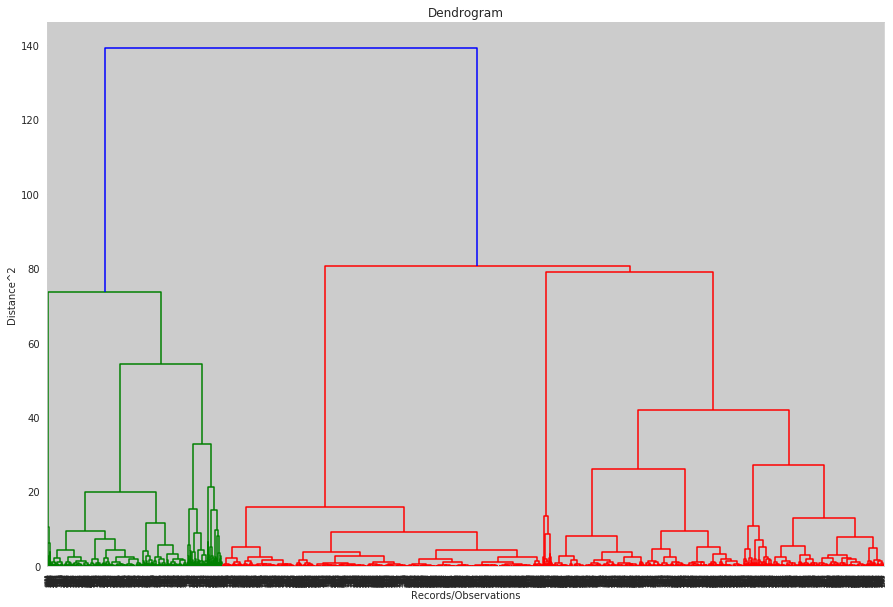

In [25]:
#Plotting a Dendrogram with "ward" linkage to determine ideal number of clusters
#for Agglomerative/Hierarchical Clustering. 

plt.figure(figsize = (15,10))
link = linkage(data_pca, method = "ward")
dend = dendrogram(link)
#plt.axhline(y = 8, linestyle = "--")
plt.xlabel("Records/Observations")
plt.ylabel("Distance^2")  #Distance square because we are using "ward" as a linkage.
plt.title("Dendrogram")

###Observation:
*   Looking at the dendrogram, we can say that ideal number of clusters can be 2 as the distance between the 2 clusters is more.



In [0]:
#Performing Agglomerative/Hierarchical Clustering on Dimension reduced dataset.
agg = AgglomerativeClustering(n_clusters = 2)
agg.fit(data_pca)

agg_labels = list(agg.labels_)

Text(0.5, 1.0, 'Scatter Plot')

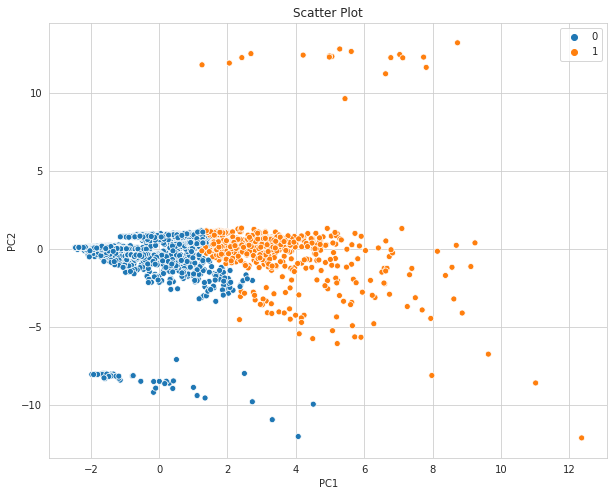

In [29]:
#Plotting scatter plot.
plt.figure(figsize = (10,8))
sns.scatterplot(data_pca["PC1"],data_pca["PC2"], data = data_pca, hue = agg_labels)
plt.title("Scatter Plot")